<a href="https://colab.research.google.com/github/AnYoujeong/final_project/blob/main/codeRecommend_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ### start end 둘다 넣은거 패딩

In [ ]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
import pandas as pd
import os
import openpyxl
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils
from tensorflow.keras.preprocessing.text import Tokenizer
from google.colab import drive
drive.mount('/content/drive')

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

In [ ]:
# 전체 코드에 들어있는 코드들 사전 정의
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/finalPJ/code_result.csv')
df_new = df.iloc[0].to_list()

#df_new
count={}

for i in df_new:
    try: count[i] += 1
    except: count[i]=1
  
new_list = []
for v in df_new:
    if v not in new_list:
        new_list.append(v)

# 코드 하나씩 분리 
code = str(new_list).split(',')

# 공백제거
code_1 = list(map(lambda s : ''.join(s.split()), code))

# ' 제거
code_2=str(code_1).replace("'","")

# str 안에있는 [,] 제거
code_3 = code_2.replace("[","")  # str에서 대괄호 없애기
code_4 = code_3.replace("]","")
code_5 = code_4.replace('"',"")

code_6 = code_5.split(",")
code_7 = list(map(lambda s : ''.join(s.split()), code_6)) # 공백 한번 더 제거

# 중복 값 제거
code_8 = []
for v in code_7:
    if v not in code_8:
        code_8.append(v)

idx2code = {i : code_8[i] for i in range(len((code_8)))}
print(idx2code)
code2idx = {string : i for i,string in enumerate(code_8)}
print(code2idx)

max_scale_value = 6.0

{0: 'Eb-7', 1: 'Ab-7', 2: 'Gb-7', 3: 'Bb-7b5', 4: 'Bb-7', 5: 'Ab7', 6: 'D-7', 7: 'Bb7b5', 8: 'Bb', 9: 'G-6', 10: 'E-7', 11: 'Fmaj7#11', 12: 'G7', 13: 'A-', 14: 'E7#9', 15: 'F', 16: 'F#-7b5', 17: 'G7sus4', 18: 'Eb7#11', 19: 'F-maj7', 20: 'C', 21: 'B7', 22: 'G', 23: 'A', 24: 'Ab7sus4', 25: 'Bb-', 26: 'Eo', 27: 'Ebmaj7', 28: 'C-7', 29: 'F7', 30: 'Bbmaj7', 31: 'A7', 32: 'F#-7', 33: 'B-7', 34: 'Dmaj7', 35: 'Db-7', 36: 'Gb7', 37: 'C7', 38: 'D-9', 39: 'D-9#5', 40: 'E-7b5', 41: 'A7b9', 42: 'G-7', 43: 'Fmaj7', 44: 'B-7b5', 45: 'A7b5b9', 46: 'A7#9', 47: 'C7sus4', 48: 'NC', 49: 'Cmaj7', 50: 'A-7', 51: 'D7', 52: 'C6', 53: 'Eb7', 54: 'C-7b5', 55: 'F7b9', 56: 'F7#5', 57: 'Bb6', 58: 'E7', 59: 'D7b9', 60: 'F#7b9', 61: 'B7#5', 62: 'Bb7', 63: 'Ab7b5', 64: 'B7alt', 65: 'Emaj7', 66: 'Db9#11', 67: 'G7#5', 68: 'G7b5', 69: 'A-7b5', 70: 'G7b9', 71: 'Gbmaj7', 72: 'C7b9', 73: 'Bb-6', 74: 'Amaj7', 75: 'Bbo7', 76: 'C#o7', 77: 'Eb-6', 78: 'F6', 79: 'F-7', 80: 'Db7#9', 81: 'C7#9', 82: 'Eb', 83: 'Db', 84: 'Dbmaj7', 

In [ ]:
# 시퀀스 데이터 정의           -> 전체 곡 코드
read_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/finalPJ/code_result2.csv')
df = pd.DataFrame(read_csv)
# df.info()
df2 = df.astype('object')  # 결측값 float을 object로 바꾸기
print(df2.dtypes)
print(df2.info())


0     object
1     object
2     object
3     object
4     object
       ...  
82    object
83    object
84    object
85    object
86    object
Length: 87, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       218 non-null    object
 1   1       218 non-null    object
 2   2       218 non-null    object
 3   3       218 non-null    object
 4   4       218 non-null    object
 5   5       218 non-null    object
 6   6       218 non-null    object
 7   7       218 non-null    object
 8   8       216 non-null    object
 9   9       214 non-null    object
 10  10      213 non-null    object
 11  11      211 non-null    object
 12  12      205 non-null    object
 13  13      204 non-null    object
 14  14      203 non-null    object
 15  15      200 non-null    object
 16  16      188 non-null    object
 17  17      185 non-null    object
 18  1

In [ ]:
# nan 제거
# df2.isnull().sum().sum()
# df2.dropna()
# print(df2.isnull().sum().sum())

code_all = df.loc[0].values.tolist()
print(len(code_all))
# print(type(code))
# print(code)

print(len(code_all))

codes = [x for x in code_all if str(x) != 'nan']
print(len(codes))
# seq = codes  # list로 바꾼 전체 곡 코드 
print(codes)

6009
6009
6004
['Eb-7', 'Eb-7', 'Eb-7', 'Eb-7', 'Ab-7', 'Gb-7', 'Eb-7', 'Eb-7', 'Bb-7b5', 'Bb-7b5', 'Eb-7', 'Eb-7', 'Eb-7', 'Eb-7', 'Eb-7', 'Eb-7', 'Ab-7', 'Gb-7', 'Eb-7', 'Eb-7', 'Bb-7', 'Bb-7', 'Eb-7', 'Eb-7', 'Ab7', 'Ab-7', 'Gb-7', 'Eb-7', 'D-7', 'Bb7b5', 'Eb-7', 'Eb-7', 'D-7', 'Bb', 'G-6', 'E-7, Fmaj7#11', 'G7, A-', 'D-7', 'E7#9', 'F', 'F#-7b5', 'G7sus4', 'G7sus4', 'Eb7#11', 'Eb7#11', 'F#-7b5', 'F-maj7', 'C', 'B7', 'G', 'A', 'F', 'Ab7sus4', 'Ab7, Bb-', 'Bb-', 'Eo, Ebmaj7', 'Ebmaj7', 'C-7', 'F7', 'Bbmaj7', 'A7', 'F#-7', 'B-7', 'E-7, A7', 'Dmaj7', 'C-7', 'F7', 'Eb-7', 'Ab7', 'C-7', 'F7', 'D-7, G7', 'Db-7, Gb7', 'C7', 'F7', 'Bbmaj7', 'A7', 'F#-7', 'B-7', 'E-7, A7', 'Dmaj7', 'D-9', 'D-9#5', 'D-9', 'D-9#5', 'D-7', 'E-7b5, A7b9', 'D-7, G-7, C7', 'Fmaj7', 'E-7b5, A7b9', 'D-7, B-7b5', 'E-7b5 ', 'A7b5b9', 'D-9', 'D-9#5', 'D-9', 'D-9#5', 'Fmaj7, D-7', 'G-7, C7', 'Fmaj7, D-7', 'G-7, A7#9', 'D-7', 'E-7b5, A7b9', 'D-7, G-7, C7', 'Fmaj7', 'E-7b5, A7b9', 'D-7', 'C7sus4', 'C7sus4', 'C7sus4', 'C7su

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/finalPJ/code_result2.csv')
# print(df.info)
start = ['start']
chord_all = []

for i in range(len(df)) :
  df_new = df.iloc[i].to_list()
  #df_new
  count={}
  
  for i in df_new :
    try: count[i] += 1
    except: count[i]=1
  new_list = []
  for v in df_new:
    if v not in new_list:
      new_list.append(v)
  #print('new_list : ',new_list)

  # 코드 하나씩 분리 
  code = str(new_list).split(',')
  #print("0 : ",code)
  code = [x for x in code if str(x) != 'nan']

  # 공백제거
  code_1 = list(map(lambda s : ''.join(s.split()), code))
  #print("1 : ",code_1)
  # ' 제거
  code_2=str(code_1).replace("'","")
  #print("2 : ",code_2)

  code_3 = code_2.replace("[","")  # str에서 대괄호 없애기
  #print("3 : ",code_3)
  code_4 = code_3.replace("]","")  # ]없애기
  #print("4 : ",code_4)

  code_5 = code_4.replace('"',"") # " 없애기
  #print("5 : ",code_5)

  code_6 = code_5.split(",")  # ,로 나누기
  # print("6 : ",code_6)
  code_7 = list(map(lambda s : ''.join(s.split()), code_6)) # 공백 한번 더 제거
  # print("7 : ",code_7)

  # 중복 값 제거
  code_8 = ['start']
  for v in code_7:
      if v not in code_8:
          code_8.append(v)
      
  code_8.extend(['end'])
  # print("8 : ",code_8)

  
  for t in code_8:
    chord_all.append(t)

print(chord_all)


['start', 'Bbmaj7', 'G7#5', 'C-7', 'F7', 'F#o7', 'G-7', 'F-7', 'E-7', 'A7', 'D-7', 'Eb-7', 'B-7b5', 'E7', 'C-7b5', 'A-7b5', 'D7', 'C7', 'Fmaj7', 'Ab-7', 'Db7', 'Bmaj7', 'nan', 'end', 'start', 'Ebmaj7', 'D-7b5', 'G7', 'C-7', 'Bb-7', 'Eb7', 'Abmaj7', 'Db9', 'F7', 'F-7', 'A-7', 'D7', 'G-7', 'C7', 'Bb7', 'Eb', 'nan', 'end', 'start', 'D-7b5', 'Db-7', 'C-7', 'B-7', 'Bb-7', 'Eb7', 'Ab6', 'Ab7', 'Eb-7', 'Dbmaj7', 'Do7', 'F-7', 'Bb7', 'Ebmaj7', 'Eo7', 'E7', 'nan', 'end', 'start', 'G7', 'C7', 'D7', 'F7', 'Bb6', 'A7', 'Ab7', 'nan', 'end', 'start', 'Bbmaj7', 'Gbmaj7', 'B7b5', 'D-7', 'G7', 'C-7', 'A-7b5', 'D7', 'G-7', 'A7#9', 'Dmaj7', 'E-7', 'A7', 'F7', 'Bb-7', 'Eb7', 'F-7', 'Bb7', 'Ebmaj7', 'Ab7', 'C7', 'nan', 'end', 'start', 'F-7', 'Bb7', 'Ebmaj7', 'Ab13', 'A-7b5', 'D7b9', 'G-7', 'C7', 'Eb6', 'D-7', 'G7', 'C-7', 'F7', 'G-7b5', 'nan', 'end', 'start', 'Ebmaj7', 'Db9', 'A-7', 'D7', 'G', 'D-7', 'Emaj7', 'D9', 'F-7', 'Bb7b9', 'nan', 'end', 'start', 'B-9', 'Cmaj7', 'Fmaj7', 'E-9', 'A-7', 'D-7', 'G-7', 

In [ ]:
newCodes = str(codes).split(',')
# 공백제거
trans_1 = list(map(lambda s : ''.join(s.split()), newCodes))
trans_2=str(trans_1).replace("'","")
# str 안에있는 [,] 제거
trans_3 = trans_2.replace("[","")
trans_4 = trans_3.replace("]","")
trans_5 = trans_4.replace('"',"")
trans_6 = trans_5.split(",")
# 공백제거
trans_7 = list(map(lambda s : ''.join(s.split()), trans_6))
seq = trans_7

In [ ]:
seq = chord_all

In [ ]:
# 2. 데이터셋 생성하기

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)

KeyError: ignored

In [ ]:
# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (8359, 4, 1)) # 샘플수 = dataset.shape *** 여기 샘플수 변경해야함

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)


one hot encoding vector size is  339


In [ ]:
# 3. 모델 구성하기
'''128 메모리 셀을 가진 LSTM 레이어 1개와 Dense 레이어로 구성
입력은 샘플이 50개, 타임스텝이 4개, 속성이 1개로 구성
상태유지(stateful) 모드 비활성화'''

model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 1), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))

In [ ]:
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 5. 모델 학습시키기
num_epochs = 100

history = LossHistory() # 손실 이력 객체 생성
history.init()

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
  

epochs : 0
8359/8359 - 32s - loss: 4.5668 - accuracy: 0.0531 - 32s/epoch - 4ms/step
epochs : 1
8359/8359 - 31s - loss: 4.3480 - accuracy: 0.0822 - 31s/epoch - 4ms/step
epochs : 2
8359/8359 - 31s - loss: 4.2410 - accuracy: 0.0977 - 31s/epoch - 4ms/step
epochs : 3
8359/8359 - 31s - loss: 4.1455 - accuracy: 0.1125 - 31s/epoch - 4ms/step
epochs : 4
8359/8359 - 30s - loss: 4.0641 - accuracy: 0.1192 - 30s/epoch - 4ms/step
epochs : 5
8359/8359 - 33s - loss: 3.9821 - accuracy: 0.1244 - 33s/epoch - 4ms/step
epochs : 6
8359/8359 - 31s - loss: 3.9018 - accuracy: 0.1381 - 31s/epoch - 4ms/step
epochs : 7
8359/8359 - 31s - loss: 3.8315 - accuracy: 0.1420 - 31s/epoch - 4ms/step
epochs : 8
8359/8359 - 30s - loss: 3.7717 - accuracy: 0.1503 - 30s/epoch - 4ms/step
epochs : 9
8359/8359 - 31s - loss: 3.7097 - accuracy: 0.1611 - 31s/epoch - 4ms/step
epochs : 10
8359/8359 - 29s - loss: 3.6540 - accuracy: 0.1644 - 29s/epoch - 4ms/step
epochs : 11
8359/8359 - 30s - loss: 3.6037 - accuracy: 0.1759 - 30s/epoch -

KeyboardInterrupt: ignored

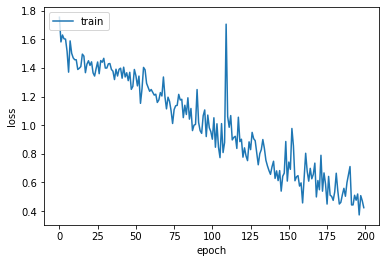

In [ ]:
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

13/13 [==============================] - 0s 3ms/step - loss: 0.4082 - accuracy: 0.8462
accuracy: 84.62%


In [ ]:
# 8. 모델 사용하기

pred_count = 4 # 최대 예측 개수 정의 = 샘플수

# 한 스텝 예측

seq_out = ['F-7', 'F-7', 'Eb7', 'Eb7']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
model.reset_states()
    
print("one step prediction : ", seq_out)

13/13 [==============================] - 0s 2ms/step
one step prediction :  ['F-7', 'F-7', 'Eb7', 'Eb7', 'Db7', 'F-7', 'F-7', 'F-7', 'F-7', 'Eb7', 'Eb7', 'F-7', 'F-7', 'Eb7,Db7', 'C7', 'F-7', 'F-7']


In [ ]:
# 곡 전체 예측

seq_in = ['F-7', 'F-7', 'Eb7', 'Eb7']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)

1/1 [==============================] - 0s 17ms/step
full song prediction :  ['F-7', 'F-7', 'Eb7', 'Eb7', 'F-7', 'F-7', 'Eb7,Db7', 'C7', 'F-7', 'F-7', 'F-7', 'Eb7', 'Eb7', 'F-7', 'F-7', 'Eb7,Db7', 'C7']
